In [1]:
% setup MRI-education-resources path and requirements
cd ../
startup

loading image
loading signal


# RF Pulses

The purpose of appling RF magnetic fields is to excite the spins.  Equivalently, this RF energy aims to flip the net magnetization.
This RF energy is referred to as an RF pulse, since the RF energy is applied for a short period of time and then switched off.

## Learning Goals

1. Describe how various types of MRI contrast are created
    * Understand how changes in flip angle are implemented
1. Manipulate MRI sequence parameters to improve performance
    * Understand how changes in flip angle are implemented

## RF Pulse Properties

### Flip Angle

The flip angle (on-resonance) is equal to the integral of the RF pulse shape, $b_1(t)$ (in units of magnetic field)):

$$\theta = \gamma \int_0^{T_{rf}} b_1(\tau) d\tau $$

### Time-bandwidth Product

The time-bandwidth product (TBW) characterizes the relationship between pulse duration, $T_{rf}$, and bandwidth, $BW_{rf}$ and is a fixed value for a given pulse shape. It is defined as

$$ TBW = T_{rf} \cdot BW_{rf} $$


### Specific Absorption Rate

The Specific Absorption Rate (SAR) measures the amount of energy absorbed by the body from a RF pulse.  Since this absorption can cause tissue heating there are safety limits on SAR.  It is proportional to the integrated total RF pulse power:

$$ SAR \propto \int_0^{T_{rf}} |b_1(\tau)|^2 d\tau $$

$T_{rf}$ is the duration of the RF pulse.
  For for MRI, SAR can cause tissue heating and thus there are SAR safety limits to minimize this heating.

## Selective RF Pulses

Another key function of RF pulses is slice-selection.  This means applying a shaped RF pulse along with a magnetic field gradient that only flips the net magnetization within a slice.

This is first achieved by applying RF pulses that are frequency selective, meaning they only contain a range of resonant frequencies and thus these are the only frequencies excited.  Illustrated in the plots below are:

1. Sinusoidal RF pulse, exciting a single resonance frequency
1. Adding multiple frequencies together to creating a "slice" of frequencies that are excited 
1. Multiple frequencies is equivalent to a sinc-shaped pulse
1. Convert this frequency profile to a slice profile with a magnetic field gradient

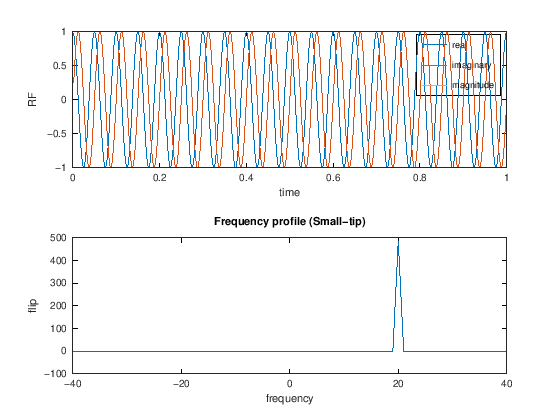

In [2]:
% Sinusoid has a single resonance frequency

dt = 0.002;
tmax = 1;
N = tmax/dt;
t = [1:N]*dt;
% frequency of RF
f0 = 20;

rf_sinusoid = exp(i*2*pi*f0*t);

f = [-N/2:N/2-1]/(N*dt);
% Fourier Transform used to approximate the RF pulse profile (small tip approximation)
FT_sinusoid = fftshift(fft(rf_sinusoid));

subplot(211)
plot(t,real(rf_sinusoid), t,imag(rf_sinusoid), t, abs(rf_sinusoid))
xlabel('time'), ylabel('RF'), legend('real','imaginary', 'magnitude')

subplot(212)
plot(f,FT_sinusoid)
title('Frequency profile (Small-tip)')
xlabel('frequency'), ylabel('flip'), xlim([-2*f0 2*f0])

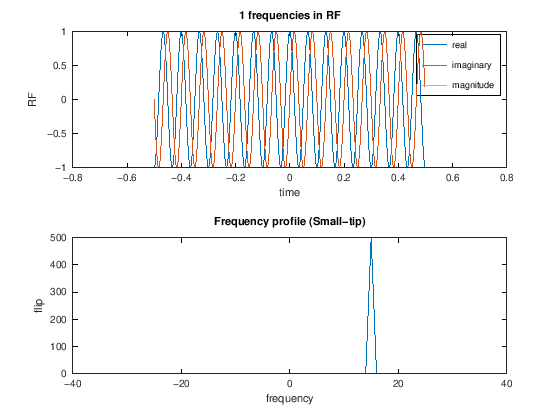

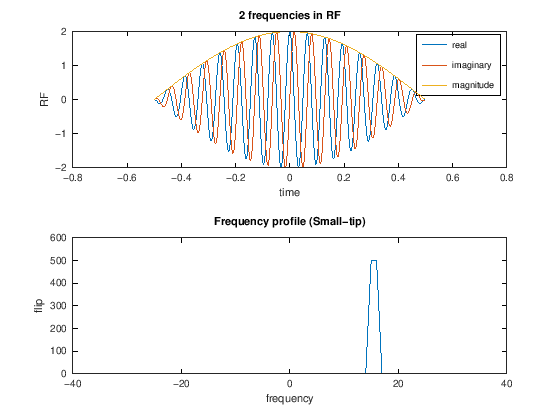

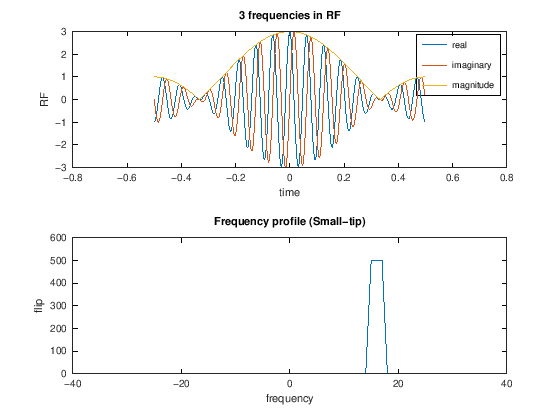

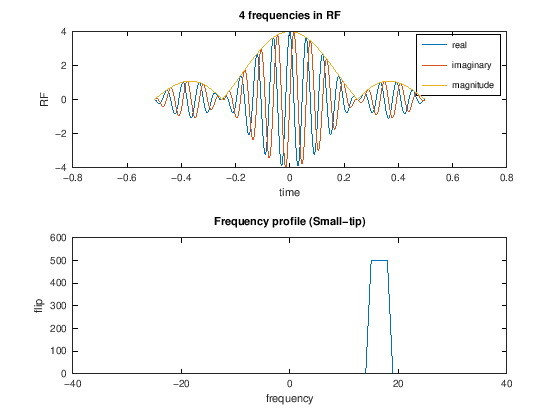

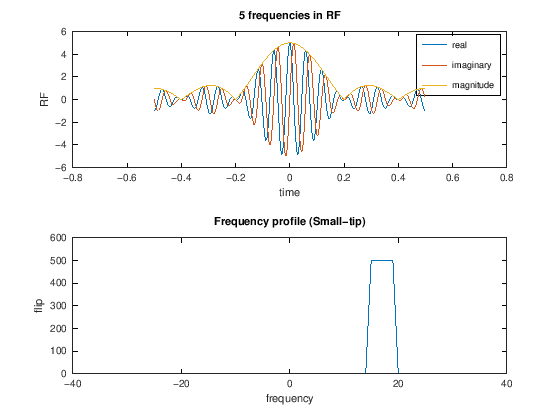

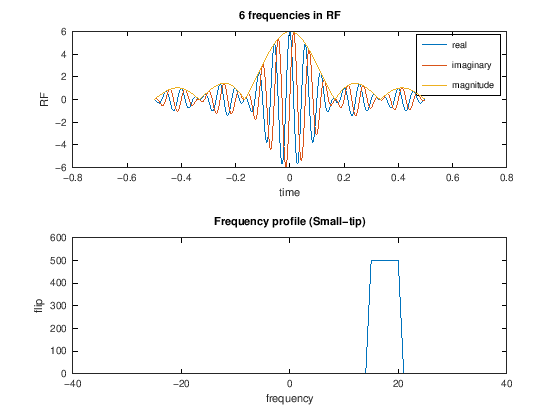

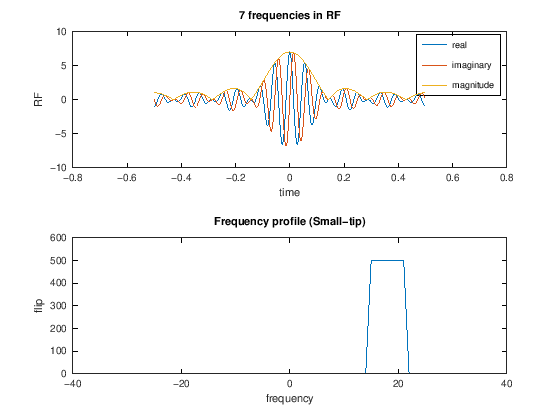

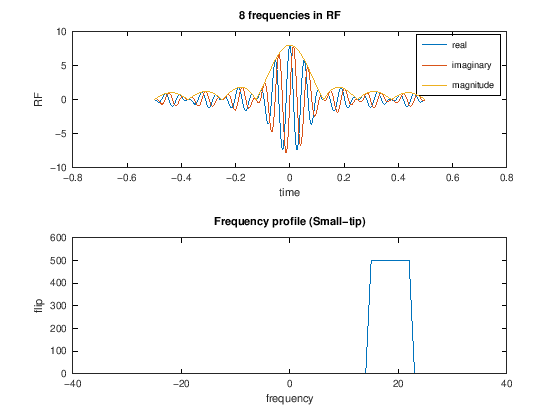

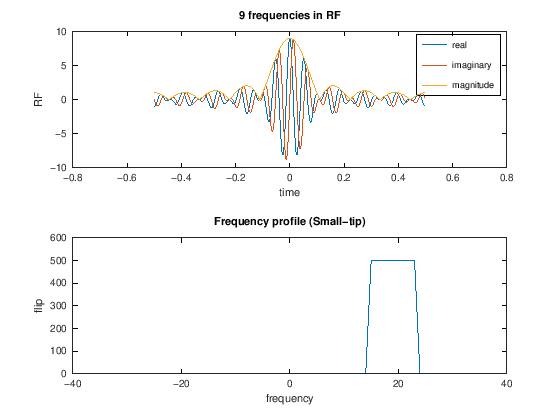

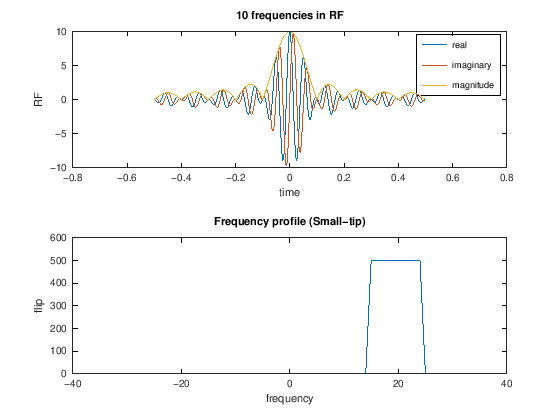

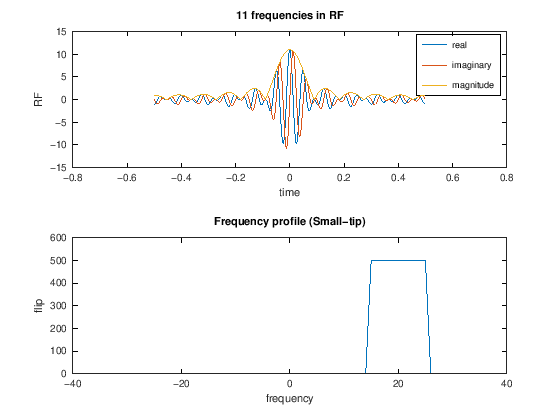

In [3]:
% To excite a slice, we create a RF pulse with a range of frequencies, used while applying magnetic field gradient


dt = 0.002;
tmax = 1;
N = tmax/dt;
t = [-N/2:N/2-1]*dt;
% center frequency of RF
f0 = 20;

% range of frequencies to sum
df = [-5:5];

[tmat dfmat] = meshgrid(t,df+f0);
rf_all = exp(i*2*pi*dfmat.*tmat);

f = [-N/2:N/2-1]/(N*dt);

for n = 1:length(df)
    rf_n = sum(rf_all(1:n,:),1);

    % Fourier Transform used to approximate the RF pulse profile (small tip approximation)
    FT_n = fftshift(fft(rf_n));

    figure
    subplot(211)
    plot(t,real(rf_n), t,imag(rf_n), t, abs(rf_n))
    xlabel('time'), ylabel('RF'), legend('real','imaginary', 'magnitude')

    title([int2str(n) ' frequencies in RF'])
    subplot(212)
    plot(f,abs(FT_n))
    title('Frequency profile (Small-tip)')
    xlabel('frequency'), ylabel('flip'), xlim([-2*f0 2*f0])

end


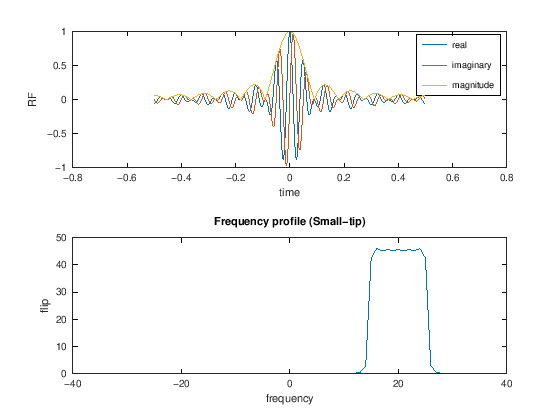

In [4]:
% This sum of sinusoids is a sinc function!


dt = 0.002;
tmax = 1;
N = tmax/dt;
t = [-N/2:N/2-1]*dt;

% frequency of RF
f0 = 20; % center frequency
fwidth = 11; % frequency range
rf_sinc = exp(i*2*pi*f0*t).*sinc(fwidth*(t));

f = [-N/2:N/2-1]/(N*dt);
% Fourier Transform used to approximate the RF pulse profile (small tip approximation)
FT_sinc = fftshift(fft(rf_sinc));

subplot(211)
plot(t,real(rf_sinc), t,imag(rf_sinc), t, abs(rf_sinc))
xlabel('time'), ylabel('RF'), legend('real','imaginary', 'magnitude')
subplot(212)
plot(f,abs(FT_sinc))
title('Frequency profile (Small-tip)')
xlabel('frequency'), ylabel('flip'), xlim([-2*f0 2*f0])

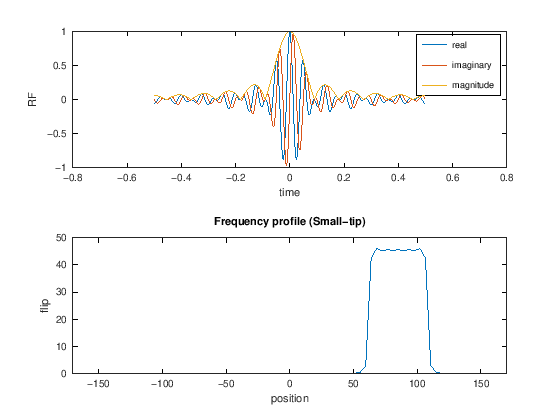

In [5]:
% Convert this plot to slice profile with gradient

Gz = .1;
gammabar = 42.58;
z = gammabar*f*Gz;

subplot(211)
plot(t,real(rf_sinc), t,imag(rf_sinc), t, abs(rf_sinc))
xlabel('time'), ylabel('RF'), legend('real','imaginary', 'magnitude')
subplot(212)
plot(z,abs(FT_sinc))
title('Frequency profile (Small-tip)')
xlabel('position'), ylabel('flip'), xlim([-2*f0*gammabar*Gz 2*f0*gammabar*Gz])

This "sum of frequencies" illustration of RF pulses is also shown in the following animations.

In the lab frame, this happens around the Larmor frequency:

![RF_pulse_frequencies-lab_frame.gif](images/RF_pulse_frequencies-lab_frame.gif)

In the rotating frame, the frequencies build up around frequency = 0

![RF_pulse_frequencies-rotating_frame.gif](images/RF_pulse_frequencies-rotating_frame.gif)

## Hard pulse versus Shaped Pulse

The first RF pulse typically introduced in MRI education is the so-called "hard" pulse - a constant amplitude pulse applied for some period of time.  As will be shown below, this pulse performs poorly for slice-selection, so shaped sinc-like pulses are used, as introduced above.  Shaped pulses create frequency profiles that excite a range of frequencies approximately uniformly (with the same flip angle), while not exciting spins outside this frequency range.


### On-resonance Excitation
We can visualize the rotation of the net magnetization as before as a rotation about the RF pulse vector, for Hard and Shaped pulses:

**hard pulse:**

![Hard Pulse on resonance](images/hard_pulse_center_frequency.gif)

**shaped pulse:**

![Shaped pulse on resonance](images/sinc_pulse_center_frequency.gif)

Looking at the on-resonance or center frequency response of a sinc-like shaped pulse, the flip angle is achieved slightly differently by tipping the net magnetization back and forth.

### Off-resonance Excitation

The flip angle provided by a hard pulse varies substantially as a function of off-resonance frequency (e.g. in the presence of a magnetic field gradient) so is not a good pulse for slice-selection.  Meanwhile, the sinc-like pulse becomes advantageous when considering a range of resonance frequencies, where this pattern of back and forth tipping leads to net magnetizations either being flipped or not:


This is illustrated by the following animation, showing net magnetizations across a range of positions when the pulse is applied with a gradient:

**hard pulse:**

![Hard pulse off resonance](images/hard_pulse_frequencies.gif)

**shaped pulse:**

![Sinc pulse off resonance](images/sinc_pulse_frequencies.gif)

These simulations are for an identical range of positions, allowing for visualization the majority of net magnetizations in this case are either at an approximate 90-degree or 0-degree excitation, with very few intermediate flip angles. that the range of resulting magnetizations from the *hard pulse* is wide, representing a spread of different flip angles at  different positions, whereas with the sinc-like pulse  the majority of net magnetizations in this case are either at an approximate 90-degree or 0-degree excitation, with very few intermediate flip angles. (Also note the refocusing gradient at the end, which is necessary for corrected for additional phase during the gradient & RF.)

This behavior can be analyzed by simulation of the RF pulse profile as well, now using the Bloch equation for a more precise simulation as compared to using Fourier Transform approximation:


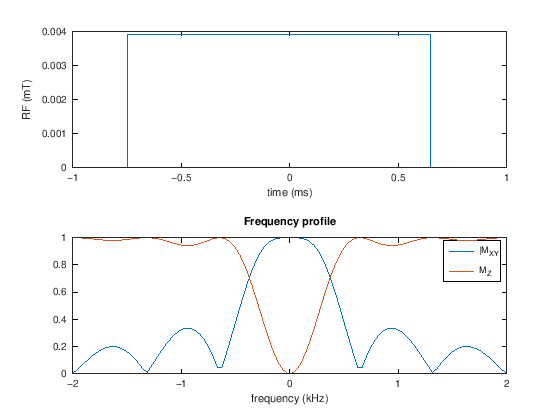

In [8]:
gammabar = 42.58; % kHz/mT

M0 = 1;
M_equilibrium = [0,0,M0].';
dt = 0.1; % ms

flip = 90;

% Hard Pulse
tmax = 1.5;
N = tmax/dt;
t = [-N/2:N/2-1]*dt;
RF = ones(1,N);
RF = (flip*pi/180)* RF/sum(RF) /(2*pi*gammabar*dt);

% B10 = (flip/360) / (gammabar*length(RF)*dt)


BW = 2; % kHz
df = linspace(-BW,BW);

M = repmat(M_equilibrium, [1, length(df)]);
for n = 1:length(t)
    for f = 1:length(df)
        M(:,f) = bloch_rotate( M(:,f), dt, [real(RF(n)),imag(RF(n)),df(f)/gammabar]);
    end
end


subplot(211)
plot([t(1)-eps,t,t(end)+eps],[0,RF,0])
xlabel('time (ms)'), ylabel('RF (mT)')
subplot(212)
plot(df,sqrt(M(1,:).^2 + M(2,:).^2), df, M(3,:))
title('Frequency profile')
xlabel('frequency (kHz)'), legend('|M_{XY}|', 'M_Z')%, ylabel('flip')

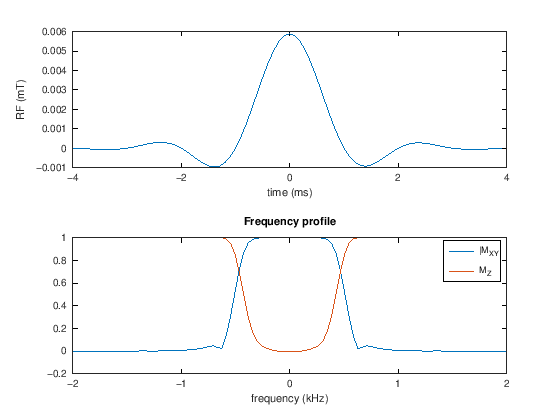

In [7]:
% Windowed Sinc Pulse
tmax = 8;
N = tmax/dt;
t = [-N/2:N/2-1]*dt;
RF =  hamming(N)' .* sinc(t);
RF = (flip*pi/180)* RF/sum(RF) /(2*pi*gammabar*dt);


M = repmat(M_equilibrium, [1, length(df)]);
for n = 1:length(t)
    for f = 1:length(df)
        M(:,f) = bloch_rotate( M(:,f), dt, [real(RF(n)),imag(RF(n)),df(f)/gammabar]);
    end
end


subplot(211)
plot(t,RF)
xlabel('time (ms)'), ylabel('RF (mT)')
subplot(212)
plot(df,sqrt(M(1,:).^2 + M(2,:).^2), df, M(3,:))
title('Frequency profile')
xlabel('frequency (kHz)'), legend('|M_{XY}|', 'M_Z')%, ylabel('flip')

## RF Pulse Design

RF pulse designs should address the limited available pulse duration and, for large flip angle designs (e.g. 90 and 180 degrees) the non-linearities in the Bloch equation.  

Limited available durations are addressed, in small flip angle pulses, by using windowing functions along with sinc pulses.  The end result are windowed sinc pulses, which have less ringing in the coil profile as illustrated below.

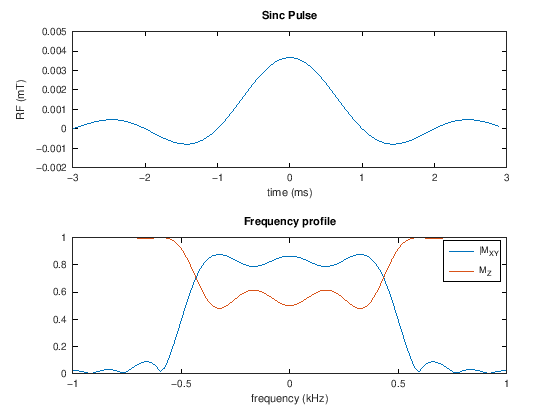

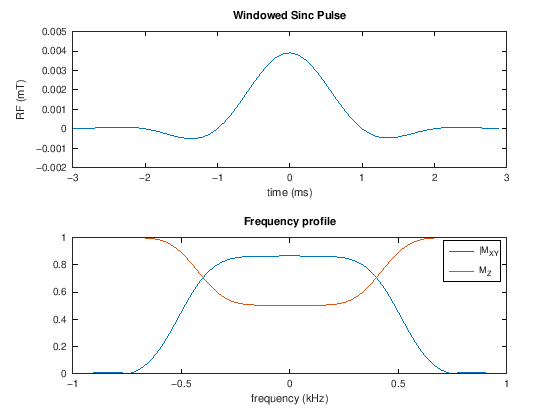

In [7]:
% windowed versus non-windowed sinc function

gammabar = 42.58; % kHz/mT

M0 = 1;
M_equilibrium = [0,0,M0].';
dt = 0.1; % ms

flip = 60;

tmax = 6;
N = tmax/dt;
t = [-N/2:N/2-1]*dt;

BW = 1; % kHz
df = linspace(-BW,BW);

% Sinc pulse
RF =  sinc(t);
RF = (flip*pi/180)* RF/sum(RF) /(2*pi*gammabar*dt);

M = repmat(M_equilibrium, [1, length(df)]);
for n = 1:length(t)
    for f = 1:length(df)
        M(:,f) = bloch_rotate( M(:,f), dt, [real(RF(n)),imag(RF(n)),df(f)/gammabar]);
    end
end

figure
subplot(211)
plot(t,RF)
xlabel('time (ms)'), ylabel('RF (mT)')
title('Sinc Pulse')
subplot(212)
plot(df,sqrt(M(1,:).^2 + M(2,:).^2), df, M(3,:))
title('Frequency profile')
xlabel('frequency (kHz)'), legend('|M_{XY}|', 'M_Z')%, ylabel('flip')

% Windowed Sinc Pulse
RF =  hamming(N)' .* sinc(t);
RF = (flip*pi/180)* RF/sum(RF) /(2*pi*gammabar*dt);


M = repmat(M_equilibrium, [1, length(df)]);
for n = 1:length(t)
    for f = 1:length(df)
        M(:,f) = bloch_rotate( M(:,f), dt, [real(RF(n)),imag(RF(n)),df(f)/gammabar]);
    end
end


figure
subplot(211)
plot(t,RF)
xlabel('time (ms)'), ylabel('RF (mT)')
title('Windowed Sinc Pulse')
subplot(212)
plot(df,sqrt(M(1,:).^2 + M(2,:).^2), df, M(3,:))
title('Frequency profile')
xlabel('frequency (kHz)'), legend('|M_{XY}|', 'M_Z')%, ylabel('flip')

### Time-bandwidth Product and Pulse Selectivity

Arguably the most important RF pulse design parameter is the "time-bandwidth" product.  As the name implies, this is the pulse duration (time) times the pulse bandwidth

$$ TBW = T_{rf} \times BW_{rf} $$

A given RF pulse shape has an associated TBW, and this shape can be stretched or shrunk in time to modulate the resulting bandwidth.

The key feature of the TBW is that it controls the _pulse selectivity_, that is how sharp the pulse profile is, or, in other words, how quickly the profile goes from the desired flip angle to zero flip angle.

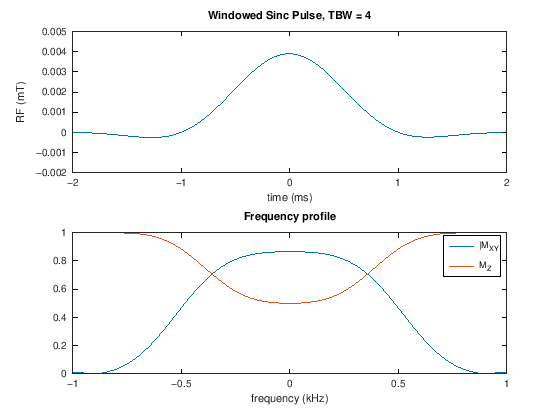

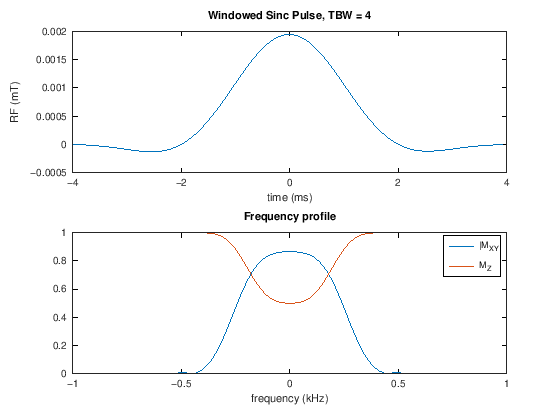

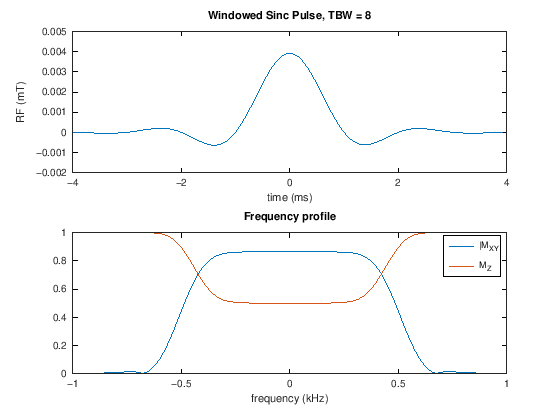

In [4]:
% Illustration of time-bandwidth product

gammabar = 42.58; % kHz/mT

M0 = 1;
M_equilibrium = [0,0,M0].';

flip = 60;
BWplot = 1; % kHz
df = linspace(-BWplot,BWplot);

% Create TBW = 4 pulse shape
TBW = 4;
N = 100;
IN = [-N/2:N/2-1]/N;
RF_shape =  hamming(N)' .*sinc(IN * TBW);

% Trf = 4 ms pulse, TBW = 4, so BWrf = TBW/Trf = 1 kHz
Trf = 4;
t = IN*Trf;
dt = Trf/N;

RF = (flip*pi/180)* RF_shape/sum(RF_shape) /(2*pi*gammabar*dt);

M = repmat(M_equilibrium, [1, length(df)]);
for n = 1:length(t)
    for f = 1:length(df)
        M(:,f) = bloch_rotate( M(:,f), dt, [real(RF(n)),imag(RF(n)),df(f)/gammabar]);
    end
end

figure
subplot(211)
plot(t,RF)
xlabel('time (ms)'), ylabel('RF (mT)')
title(['Windowed Sinc Pulse, TBW = ' int2str(TBW)])
subplot(212)
plot(df,sqrt(M(1,:).^2 + M(2,:).^2), df, M(3,:))
title('Frequency profile')
xlabel('frequency (kHz)'), legend('|M_{XY}|', 'M_Z')%, ylabel('flip')


% Trf = 8 ms pulse, TBW = 4, so BWrf = TBW/Trf = 0.5 kHz
Trf = 8;
t = IN*Trf;
dt = Trf/N;

RF = (flip*pi/180)* RF_shape/sum(RF_shape) /(2*pi*gammabar*dt);

M = repmat(M_equilibrium, [1, length(df)]);
for n = 1:length(t)
    for f = 1:length(df)
        M(:,f) = bloch_rotate( M(:,f), dt, [real(RF(n)),imag(RF(n)),df(f)/gammabar]);
    end
end

figure
subplot(211)
plot(t,RF)
xlabel('time (ms)'), ylabel('RF (mT)')
title(['Windowed Sinc Pulse, TBW = ' int2str(TBW)])
subplot(212)
plot(df,sqrt(M(1,:).^2 + M(2,:).^2), df, M(3,:))
title('Frequency profile')
xlabel('frequency (kHz)'), legend('|M_{XY}|', 'M_Z')%, ylabel('flip')


% Create TBW = 8 pulse shape
TBW = 8;
N = 100;
IN = [-N/2:N/2-1]/N;
RF_shape =  hamming(N)' .*sinc(IN * TBW);

% Trf = 8 ms pulse, TBW = 8, so BWrf = TBW/Trf = 1 kHz
Trf = 8;
t = IN*Trf;
dt = Trf/N;

RF = (flip*pi/180)* RF_shape/sum(RF_shape) /(2*pi*gammabar*dt);

M = repmat(M_equilibrium, [1, length(df)]);
for n = 1:length(t)
    for f = 1:length(df)
        M(:,f) = bloch_rotate( M(:,f), dt, [real(RF(n)),imag(RF(n)),df(f)/gammabar]);
    end
end

figure
subplot(211)
plot(t,RF)
xlabel('time (ms)'), ylabel('RF (mT)')
title(['Windowed Sinc Pulse, TBW = ' int2str(TBW)])
subplot(212)
plot(df,sqrt(M(1,:).^2 + M(2,:).^2), df, M(3,:))
title('Frequency profile')
xlabel('frequency (kHz)'), legend('|M_{XY}|', 'M_Z')%, ylabel('flip')


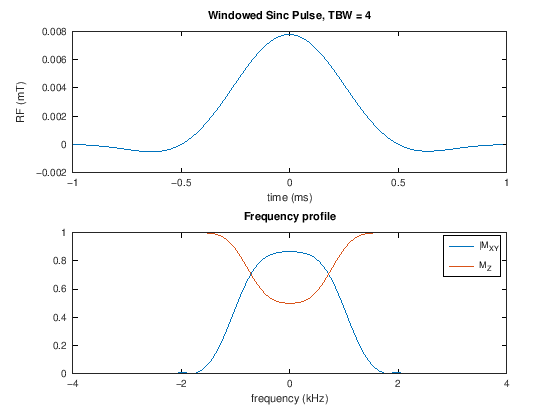

In [6]:
% Play around with the time-bandwidth product!!
TBW = 4;
Trf = 2;

gammabar = 42.58; % kHz/mT

M0 = 1;
M_equilibrium = [0,0,M0].';

flip = 60;
BWplot = 4; % kHz
df = linspace(-BWplot,BWplot);

N = 100;
IN = [-N/2:N/2-1]/N;
RF_shape =  hamming(N)' .*sinc(IN * TBW);

t = IN*Trf;
dt = Trf/N;

RF = (flip*pi/180)* RF_shape/sum(RF_shape) /(2*pi*gammabar*dt);

M = repmat(M_equilibrium, [1, length(df)]);
for n = 1:length(t)
    for f = 1:length(df)
        M(:,f) = bloch_rotate( M(:,f), dt, [real(RF(n)),imag(RF(n)),df(f)/gammabar]);
    end
end

figure
subplot(211)
plot(t,RF)
xlabel('time (ms)'), ylabel('RF (mT)')
title(['Windowed Sinc Pulse, TBW = ' int2str(TBW)])
subplot(212)
plot(df,sqrt(M(1,:).^2 + M(2,:).^2), df, M(3,:))
title('Frequency profile')
xlabel('frequency (kHz)'), legend('|M_{XY}|', 'M_Z')%, ylabel('flip')

Notice that the higher TBW pulse has much sharper frequency profile for the same pulse duration!  (But also higher peak power.)

### High flip angle pulse design


For small flip angles, the frequency profile of a RF pulse is approximately given by the Fourier Transform.  However, non-linearities in the Bloch equation cause this approximation to break down for large flip angles, as shown below by the resulting "ripples" in the frequency profile when the flip angle of the windowed.


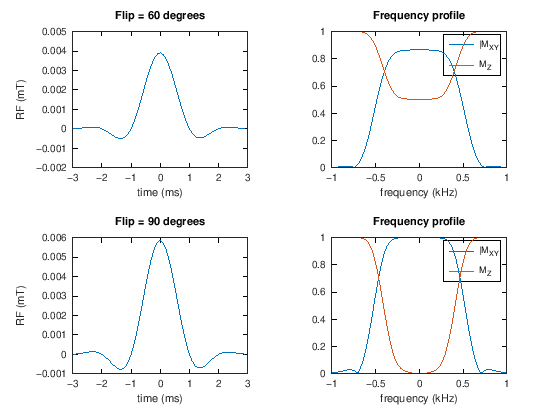

In [10]:
% small tip vs large tip
gammabar = 42.58; % kHz/mT

M0 = 1;
M_equilibrium = [0,0,M0].';
dt = 0.1; % ms

tmax = 6;
N = tmax/dt;
t = [-N/2:N/2-1]*dt;

BW = 1; % kHz
df = linspace(-BW,BW);

% Windowed Sinc Pulse
RF =  hamming(N)' .* sinc(t);

flip = 60;
RF = (flip*pi/180)* RF/sum(RF) /(2*pi*gammabar*dt);

M = repmat(M_equilibrium, [1, length(df)]);
for n = 1:length(t)
    for f = 1:length(df)
        M(:,f) = bloch_rotate( M(:,f), dt, [real(RF(n)),imag(RF(n)),df(f)/gammabar]);
    end
end


subplot(221)
plot(t,RF)
xlabel('time (ms)'), ylabel('RF (mT)')
title(['Flip = ' int2str(flip) ' degrees'])
subplot(222)
plot(df,sqrt(M(1,:).^2 + M(2,:).^2), df, M(3,:))
title('Frequency profile')
xlabel('frequency (kHz)'),legend('|M_{XY}|', 'M_Z')%, ylabel('flip')


flip = 90;
RF = (flip*pi/180)* RF/sum(RF) /(2*pi*gammabar*dt);

M = repmat(M_equilibrium, [1, length(df)]);
for n = 1:length(t)
    for f = 1:length(df)
        M(:,f) = bloch_rotate( M(:,f), dt, [real(RF(n)),imag(RF(n)),df(f)/gammabar]);
    end
end

subplot(223)
plot(t,RF)
xlabel('time (ms)'), ylabel('RF (mT)')
title(['Flip = ' int2str(flip) ' degrees'])
subplot(224)
plot(df,sqrt(M(1,:).^2 + M(2,:).^2), df, M(3,:))
title('Frequency profile')
xlabel('frequency (kHz)'),legend('|M_{XY}|', 'M_Z')%, ylabel('flip')



Note that with Fourier Transform based design small ripples that appear outside the desired slice.

The solution is to use a more sophisticated pulse design that takes into account these non-linearities, such as the Shinnar-Le Roux (SLR) transform.

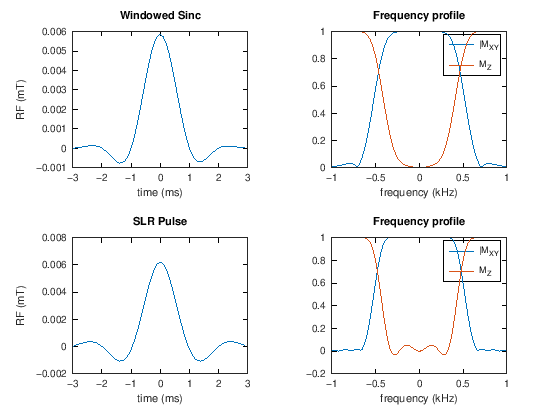

In [9]:
% Large tip pulse designs
gammabar = 42.58; % kHz/mT

M0 = 1;
M_equilibrium = [0,0,M0].';
dt = 0.1; % ms

tmax = 6;
N = tmax/dt;
t = [-N/2:N/2-1]*dt;

BW = 1; % kHz
df = linspace(-BW,BW);

% Windowed Sinc Pulse
RF =  hamming(N)' .* sinc(t);

flip = 90;
RF = (flip*pi/180)* RF/sum(RF) /(2*pi*gammabar*dt);

M = repmat(M_equilibrium, [1, length(df)]);
for n = 1:length(t)
    for f = 1:length(df)
        M(:,f) = bloch_rotate( M(:,f), dt, [real(RF(n)),imag(RF(n)),df(f)/gammabar]);
    end
end


subplot(221)
plot(t,RF)
xlabel('time (ms)'), ylabel('RF (mT)')
title(['Windowed Sinc'])
subplot(222)
plot(df,sqrt(M(1,:).^2 + M(2,:).^2), df, M(3,:))
title('Frequency profile')
xlabel('frequency (kHz)'),legend('|M_{XY}|', 'M_Z')%, ylabel('flip')

% Shinnar-Le Roux (SLR) Pulse design
RF = dzrf(N-1, tmax*1, 'ex');
RF = (flip*pi/180)* [0,RF]/sum(RF) /(2*pi*gammabar*dt);

M = repmat(M_equilibrium, [1, length(df)]);
for n = 1:length(t)
    for f = 1:length(df)
        M(:,f) = bloch_rotate( M(:,f), dt, [real(RF(n)),imag(RF(n)),df(f)/gammabar]);
    end
end

subplot(223)
plot(t,RF)
xlabel('time (ms)'), ylabel('RF (mT)')
title(['SLR Pulse'])
subplot(224)
plot(df,sqrt(M(1,:).^2 + M(2,:).^2), df, M(3,:))
title('Frequency profile')
xlabel('frequency (kHz)'),legend('|M_{XY}|', 'M_Z')%, ylabel('flip')


Note that now the ripples in the $M_{XY}$ profile are now removed!  (There is some increased ripple in $M_Z$, but this isn't an issue for excitation pulses).  The RF pulses themselves are only subtly different.

The degradation of the slice (frequency) profile of sinc-pulses becomes substantial with a 180-degree flip angle inversion pulse:

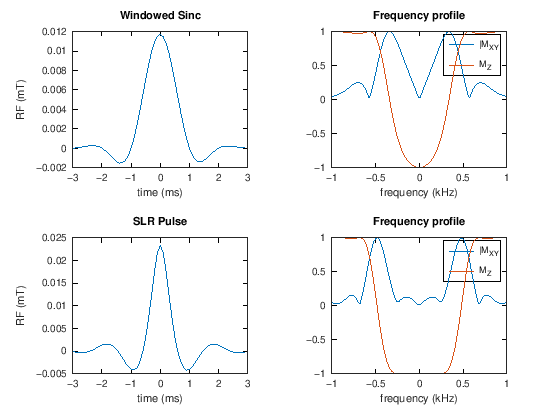

In [11]:
% Inversion (large-tip) pulses
gammabar = 42.58; % kHz/mT

M0 = 1;
M_equilibrium = [0,0,M0].';
dt = 0.1; % ms

tmax = 6;
N = tmax/dt;
t = [-N/2:N/2-1]*dt;

BW = 1; % kHz
df = linspace(-BW,BW);

% Windowed Sinc Pulse
RF =  hamming(N)' .* sinc(t);

flip = 180;
RF = (flip*pi/180)* RF/sum(RF) /(2*pi*gammabar*dt);

M = repmat(M_equilibrium, [1, length(df)]);
for n = 1:length(t)
    for f = 1:length(df)
        M(:,f) = bloch_rotate( M(:,f), dt, [real(RF(n)),imag(RF(n)),df(f)/gammabar]);
    end
end


subplot(221)
plot(t,RF)
xlabel('time (ms)'), ylabel('RF (mT)')
title(['Windowed Sinc'])
subplot(222)
plot(df,sqrt(M(1,:).^2 + M(2,:).^2), df, M(3,:))
title('Frequency profile')
xlabel('frequency (kHz)'),legend('|M_{XY}|', 'M_Z')%, ylabel('flip')

% Shinnar-Le Roux (SLR) Pulse design
RF = dzrf(N-1, tmax*1, 'inv');
RF = (flip*pi/180)* [0,RF]/sum(RF) /(2*pi*gammabar*dt);

M = repmat(M_equilibrium, [1, length(df)]);
for n = 1:length(t)
    for f = 1:length(df)
        M(:,f) = bloch_rotate( M(:,f), dt, [real(RF(n)),imag(RF(n)),df(f)/gammabar]);
    end
end

subplot(223)
plot(t,RF)
xlabel('time (ms)'), ylabel('RF (mT)')
title(['SLR Pulse'])
subplot(224)
plot(df,sqrt(M(1,:).^2 + M(2,:).^2), df, M(3,:))
title('Frequency profile')
xlabel('frequency (kHz)'),legend('|M_{XY}|', 'M_Z')%, ylabel('flip')


Note that the inversion profile $M_Z$ is much more selective, in other words more like a rectangular function, with the SLR pulse design.    The SLR RF pulse is now noticeably different from a windowed sinc.